In [2]:
# necessary utility libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# nltk for text preprocessing
from nltk.stem import WordNetLemmatizer

# sklearn for preprocessing data and for evaluating the metrics
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, log_loss, plot_confusion_matrix

# nlpaug for class imbalance handling
import nlpaug.augmenter.word as naw

# keras for neural network
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Conv1D, GlobalMaxPool1D

#### Importing the train and test files

In [3]:
df_train = pd.read_csv('./data/sentiment_train.csv')
df_test = pd.read_csv('./data/sentiment_test.csv')

df_train.head()

,Sentence,Polarity
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


#### Observing and handling the class imbalance problem

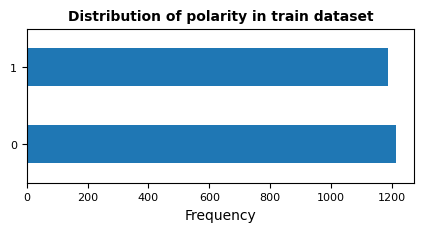

0    1213
1    1187
Name: Polarity, dtype: int64


In [4]:
# Plot sentiment distribution
df_train['Polarity'].value_counts().plot(kind = 'barh', figsize = (5,2));
plt.title('Distribution of polarity in train dataset', fontsize = 10, weight = 'bold')
plt.xlabel('Frequency', fontsize = 10)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.show()

print(df_train['Polarity'].value_counts())

We can observe here that the training data is not hugely imbalanced and there is only a slight difference between the number of training instances we have for negative and positive polarity sentences. We can easily mitigate this by using a text augmentation method called backtranslation.

The back-translation process works in the following way:
* Take some sentence and translate to another language
* Translate the output sentence back to original language
* Check if the new sentence is different from the original sentence. If it is, then we use this new sentence as an augmented version of the original text.

In [5]:
back_translation_aug = naw.BackTranslationAug(
    from_model_name='facebook/wmt19-en-de', 
    to_model_name='facebook/wmt19-de-en'
)
    
def generate_augmented_text(text):
    augmented_text = back_translation_aug.augment(text)
    return augmented_text

In [6]:
# Example of text augmentation:

text = df_train['Sentence'][979]
print("Original Text: ", text)
print()
print("Augmented Text: ", generate_augmented_text(text))

Original Text:  I kept looking at the time and it had soon become 35 minutes, yet still no food.



/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


Augmented Text:  I looked at the time again and again and soon it was 35 minutes, but still no food.


In [7]:
long_pos_texts = df_train[(df_train['Polarity'] == 1) & 
                          (df_train['Sentence'].str.len() >= 70)]['Sentence'].values

count = 0
for text in tqdm(long_pos_texts):
    new_text = generate_augmented_text(text)
    if new_text != text:
        count += 1
        df_train = df_train.append({"Sentence": new_text, "Polarity": 1}, ignore_index=True)
        if count == 26:
            break

  7%|▋         | 28/378 [00:34<07:14,  1.24s/it]


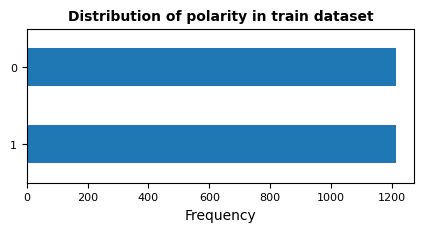

1    1213
0    1213
Name: Polarity, dtype: int64


In [8]:
# Plot sentiment distribution
df_train['Polarity'].value_counts().plot(kind = 'barh', figsize = (5,2));
plt.title('Distribution of polarity in train dataset', fontsize = 10, weight = 'bold')
plt.xlabel('Frequency', fontsize = 10)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.show()

print(df_train['Polarity'].value_counts())

We can now see that the data is perfectly balanced now and we have equal number of both positive and negative polarity examples. We can proceed ahead now with preprocessing and training our model.

#### Preprocessing and vectorizing the data for training

In [9]:
MAX_SEQ_LEN = 85 # Maximum length of sentence the model will handle
DEFAULT_BATCH_SIZE = 128 # Size of number of instances in a batch the model will take while training

It is important that we clean and preprocess the text a bit before we can use it for training purposes. So, for text cleaning purpose, we will perform the following steps:


* Contraction check: check if there’s any contracted form, and replace it with its original form
* Parsing: done with Spacy
* Filtering punctuation, white space while keeping the text content intact
* Lemmatized the words in the text. Lemmatization is basically the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. (eg. going will be lemmatized to go)

In [10]:
CONTRACTION_MAPPING = {"ain't": "is not", "aren't": "are not","can't": "cannot", "cant": "cannot",
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [11]:
lemmatizer = WordNetLemmatizer()

def clean_text(text, mapping):
    replace_white_space = ["\n"]
    for s in replace_white_space:
        text = text.replace(s, " ")
    replace_punctuation = ["’", "‘", "´", "`", "\'", r"\'"]
    for s in replace_punctuation:
        text = text.replace(s, "'")
    
    mapped_string = []
    for t in text.split(" "):
        if t in mapping:
            mapped_string.append(mapping[t])
        elif t.lower() in mapping:
            mapped_string.append(mapping[t.lower()])
        else:
            mapped_string.append(lemmatizer.lemmatize(t))
    return ' '.join(mapped_string)

X_train = [clean_text(text, CONTRACTION_MAPPING) for text in df_train['Sentence'].values]
X_test = [clean_text(text, CONTRACTION_MAPPING) for text in df_test['Sentence'].values]

Next we tokenize each of the preprocessed texts, which involves converting each sequence into an integer encoded represenation and normalizing the length of the sequences (by using padding). Please note very little pre-processing was done to the text. More specifically there's no stemming or POS tagging, common in NLP tasks. Additionally, text is left in original case (i.e not cast to lowercase). The data already is pretty clean to work with.

In [12]:
# tokenize the sentences
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# pad the sequences
X_train = pad_sequences(X_train, maxlen=MAX_SEQ_LEN)
X_test = pad_sequences(X_test, maxlen=MAX_SEQ_LEN)

print('Number of Tokens:', len(tokenizer.word_index))
print("Max Token Index:", X_train.max(), "\n")

print('Sample Text Before Processing:', df_train['Sentence'].values[2390])
print('Sample Text After Processing:', tokenizer.sequences_to_texts([X_train[2390]]), '\n')

print('What the model will interpret:', X_train[2390].tolist())

Number of Tokens: 4493
Max Token Index: 4493 

Sample Text Before Processing: Though The Wind and the Lion is told largely through the eyes of the son, every member of the family can identify with one of the characters, whether it be Sean Connery's noble brigand, Candace Bergen's feisty heroine, John Huston's wily John Hay or Steve Kanaly's spiffy, radiant, ruthless can-do lieutenant, Roosevelt's "Big Stick".  
Sample Text After Processing: ["Though The Wind and the Lion is told largely through the eye of the son every member of the family can identify with one of the characters whether it be Sean Connery's noble brigand Candace Bergen's feisty heroine John Huston's wily John Hay or Steve Kanaly's spiffy radiant ruthless can do lieutenant Roosevelt's Big Stick"] 

What the model will interpret: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4431, 11, 1195, 2, 1, 1196, 5, 523, 1270, 481, 1, 793, 10, 1, 766, 146, 4432, 10, 1, 277, 82, 4433, 15,

We will prepare the output data as well. In this case the sentiment is classified as Negative or Positive. To make it suitable for a deep learning model each sentiment will be converted to a vector of length 2, where each position corresponds to a sentiment class: Negative = 0 and Positive = 1.

In [13]:
# One Hot Encode Y values:
encoder = LabelEncoder()

y_train = encoder.fit_transform(df_train['Polarity'].values)
y_train = to_categorical(y_train) 

y_test = encoder.fit_transform(df_test['Polarity'].values)
y_test = to_categorical(y_test) 

#### Loading glove embeddings

We can easily access pre-trained word vectors for training purposes in NLP that are trained against billions of documents. These are generally recommended for NLP tasks as they provide a substantial increase in performance over embeddings trained on the fly.

This is a form of Transfer Learning where existing model weights are re-purposed for a new task (this much more prevalent amongst Image Classification tasks).
We'll use the GloVe Embeddings, which are trained on several different text sources.

In [15]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

def get_embdedings_matrix(embeddings_index, word_index, nb_words = None):
    all_embs = np.stack(embeddings_index.values())
    print('Shape of Full Embeddding Matrix', all_embs.shape)
    embed_dims = all_embs.shape[1]
    emb_mean,emb_std = all_embs.mean(), all_embs.std()

    #best to free up memory, given the size, which is usually ~3-4GB in memory
    del all_embs
    if nb_words is None:
        nb_words = len(word_index)
    else:
        nb_words = min(nb_words, len(word_index))
    
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words+1, embed_dims))
    found_vectors = 0
    words_not_found = []
    for word, i in tqdm(word_index.items()):
        if i >= nb_words: 
            continue
        embedding_vector = None
        if word in embeddings_index:
            embedding_vector = embeddings_index.get(word)
        elif word.lower() in embeddings_index:
            embedding_vector = embeddings_index.get(word.lower())
        elif '#'+word.lower() in embeddings_index:
            embedding_vector = embeddings_index.get('#'+word.lower())
            
        if embedding_vector is not None: 
            found_vectors += 1
            embedding_matrix[i] = embedding_vector
        else:
            words_not_found.append((word, i))

    print("% of Vectors found in Corpus", found_vectors / nb_words)
    return embedding_matrix, words_not_found

In [16]:
def load_emb_matrix(word_index):
    embed_file_path = './glove.6B.300d.txt'
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in tqdm(open(embed_file_path)))
    print("Built Embedding Index:", len(embeddings_index))
    return get_embdedings_matrix(embeddings_index, word_index)

print('Loading Glove Model...')

emb_matrix, words_not_found = load_emb_matrix(tokenizer.word_index)

Loading Glove Model...


400000it [00:25, 15653.37it/s]
/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if __name__ == '__main__':


Built Embedding Index: 400000
Shape of Full Embeddding Matrix (400000, 300)


100%|██████████| 4493/4493 [00:00<00:00, 425981.78it/s]

% of Vectors found in Corpus 0.9561540173603383


#### Building the keras model and performing parameter tuning with cross validation

The neural nets we'll be using is based on Recurrent Neural Network(RNN) Architecture.

An RNN is a specific type of Deep Learning Architecture that's specially adapted to handle time dependent information such as human language (e.g. Text, Audio), signal outputs from an IoT Device, or any other Time Series based data(stock prices, though not recommeneded). An LSTM is a specific type of RNN and is used in a lot of commercial applications(Siri), also consider GRU's, which can occasionally outperform LSTMs on certain tasks and ther are more advanced models as well (like Attention, BERT, 1D Convolutions, Capsules, etc)

In our neural network model we use the following layers:

* Embedding - Matrix of Word Vectors, where each vector store the "meaning" of the word. These can be trained on the fly or you can leverage existing pre-trained vector.

* LSTM - Recurrent Neural Network that allows for the "building" of state over time

* Dense - Feed Forward Neural Net used to interpret the LSTM Output

* Bi-Directional LSTM - As the name suggest this Layer "reads" text both forwards and backwards and allows the model to get information from past and future states simultaneously. It also usually provides a nice boost in performance over the single pass LSTM.

* Dropout - It is added to reduce overfitting, as the number of paramters in the model increases. A Dropout Layer, drops data from the input, but only during training, which encourages the model to be more "robust" and not become overly dependent on specific signals from the training data to make predictions. Since we have a relatively small data-set compared to our model size, drop-out is critical to ensure the model doesnt just quickly overfit the training set.

In [17]:
def build_model(embed_matrix=emb_matrix, optimizer='adam', spatial_dropout=0.3, lstm_dropout=0.25, lstm_units=128):
    model = Sequential()
    model.add(Embedding(input_dim = embed_matrix.shape[0], output_dim=embed_matrix.shape[1], 
                        input_length=MAX_SEQ_LEN, weights=[embed_matrix], trainable=False))
    model.add(SpatialDropout1D(spatial_dropout))
    model.add(Bidirectional(LSTM(lstm_units, dropout=lstm_dropout, recurrent_dropout=lstm_dropout, return_sequences=True)))
    model.add(Conv1D(64, 4))
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    print(model.summary())
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

A Deep Neural Network that can generalize well to new data is a very challenging problem. Furthermore, Deep learning models are full of hyper-parameters and finding the optimal ones can be a tedious process. To solve this, we can use parameter tuning methods like gridsearch or randomized search. Sklearn already provides these implementations. We will be going ahead with Randomized Search as it takes less time as compared to Grid Search with minimal affect on the results. By defining the search parameters, we provide the hyperparameter tuning tool to choose the best possible combinations among them to build a highly generalized deep learning model that can work on any unseen data in future. Additionally, randomized search can perform cross validation splits in order to determine the best parameters. This is a great method when we have limited amount of data to train our model on.

In [18]:
keras_estimator = KerasClassifier(build_fn=build_model, verbose=1)

# define the randomized search parameters
param_grid = {
    'epochs': [25, 30, 35],
    'optimizer':['RMSprop', 'adam'],
    'spatial_dropout': [0.2, 0.3, 0.4],
    'lstm_dropout': [0.20, 0.25, 0.30],
    'lstm_units': [64, 128, 256],
    'batch_size':[32, 64, 128],
}

In [19]:
kfold_splits = 5

random_search = RandomizedSearchCV(estimator=keras_estimator,  
                          n_jobs=-1, 
                          verbose=2,
                          refit=False,
                          scoring='f1',
                          cv=kfold_splits,
                          error_score='raise',
                          return_train_score=True,
                          param_distributions=param_grid)

tuning_results = random_search.fit(X_train, np.argmax(y_train, axis=1), ) 


# summarize results
print("Best: %f using %s" % (tuning_results.best_score_, tuning_results.best_params_))
means = tuning_results.cv_results_['mean_test_score']
stds = tuning_results.cv_results_['std_test_score']
params = tuning_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best: 0.871615 using {'spatial_dropout': 0.4, 'optimizer': 'adam', 'lstm_units': 128, 'lstm_dropout': 0.3, 'epochs': 35, 'batch_size': 64}
0.865742 (0.038547) with: {'spatial_dropout': 0.2, 'optimizer': 'RMSprop', 'lstm_units': 128, 'lstm_dropout': 0.2, 'epochs': 30, 'batch_size': 64}
0.871182 (0.021168) with: {'spatial_dropout': 0.3, 'optimizer': 'RMSprop', 'lstm_units': 256, 'lstm_dropout': 0.3, 'epochs': 35, 'batch_size': 128}
0.866133 (0.033684) with: {'spatial_dropout': 0.2, 'optimizer': 'adam', 'lstm_units': 128, 'lstm_dropout': 0.2, 'epochs': 25, 'batch_size': 32}
0.853086 (0.037047) with: {'spatial_dropout': 0.3, 'optimizer': 'adam', 'lstm_units': 128, 'lstm_dropout': 0.2, 'epochs': 25, 'batch_size': 128}
0.852464 (0.050919) with: {'spatial_dropout': 0.2, 'optimizer': 'RMSprop', 'lstm_units': 128, 'lstm_dropout': 0.25, 'epochs': 25, 'batch_size': 64}
0.858274 (0.033303) with: {'spatial_dropout': 0.4, 'optimizer': 'ada

In [20]:
tuning_results.best_params_

{'spatial_dropout': 0.4,
 'optimizer': 'adam',
 'lstm_units': 128,
 'lstm_dropout': 0.3,
 'epochs': 35,
 'batch_size': 64}

#### Training the final model with the best parameters and testing the model on unseen test data

Through hyperparameter optimization, we have got the best parameters to train our model on. So we will select the best parameters as given by Randomized Search and train our model using all of the data in the train set. After training the model, we can check the model's performance as to how well it generalizes by generating metrics on unseen test data.

In [68]:
final_model = build_model(embed_matrix=emb_matrix, optimizer='adam', spatial_dropout=0.4, lstm_dropout=0.3, lstm_units=128)

final_model.fit(X_train, y_train, epochs=35, batch_size=64, class_weight=None,
                callbacks= [ModelCheckpoint('model.hdf5', monitor='loss', 
                                            verbose=1, save_best_only=True)], 
                verbose=2)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 85, 300)           1348200   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 85, 300)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 85, 256)           439296    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 82, 64)            65600     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 2)                

We can now evaluate the trained model on the unseen test data and see how the model performs on it.

In [69]:
final_model = load_model('model.hdf5')
predictions = final_model.predict(X_test, verbose=1)

print('Test Accuracy', (predictions.argmax(axis = 1) == y_test.argmax(axis = 1)).mean())
print('F1 Score on Test Set:', f1_score(y_test.argmax(axis = 1), predictions.argmax(axis = 1), average='weighted'))
print(confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1)))

19/19 [==============================] - 1s 16ms/step
Test Accuracy 0.8233333333333334
F1 Score on Test Set: 0.8233333333333334
[[234  53]
 [ 53 260]]


In [87]:
all_preds = []
for idx, (actual, pred) in enumerate(zip(y_test.argmax(axis = 1), predictions.argmax(axis = 1))):
    all_preds.append({"Sentence" : df_test["Sentence"].iloc[idx],
                      "Polarity-Actual": actual,
                      "Polarity-Predicted" : pred})
df_preds = pd.DataFrame(all_preds)
df_preds.head()

,Sentence,Polarity-Actual,Polarity-Predicted
0,A good commentary of today's love and undoubte...,1,1
1,For people who are first timers in film making...,1,1
2,"It was very popular when I was in the cinema, ...",1,1
3,It's a feel-good film and that's how I felt wh...,1,1
4,It has northern humour and positive about the ...,1,1


In [88]:
df_preds.to_csv('./data/sentiment_test_preds.csv', index=False)